# ICT3214 Security Analytics - Coursework 2
# Email Phishing Detection: ML/AI Model Comparison

## Overview
This notebook demonstrates three different machine learning approaches for detecting phishing emails:
1. **Random Forest** - Traditional ensemble learning
2. **XGBoost** - Gradient boosting with advanced text features
3. **LLM-GRPO** - Large Language Model with Group Relative Policy Optimization

## Dataset
**Enron Email Corpus** - 29,767 labeled emails (legitimate + phishing)

---

## Table of Contents
1. [Environment Setup & Repository Clone](#setup)
2. [Model 1: Random Forest Training](#rf)
3. [Model 2: XGBoost Training](#xgboost)
4. [Model 3: LLM-GRPO Evaluation](#llm)
5. [(Optional) Train Your Own LLM-GRPO](#train-llm)
6. [Model Comparison & Visualization](#comparison)
7. [FastAPI Gateway for All Models](#api-gateway)
8. [Splunk SIEM Integration](#splunk)

---
# 1. Environment Setup & Repository Clone <a name="setup"></a>

In [1]:
# Check if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
    print("Running in Google Colab")
except:
    IN_COLAB = False
    print("Running locally")

Running in Google Colab


In [2]:
# Clone the repository (fresh clone each time)
import os
import shutil
import subprocess

REPO_URL = "https://github.com/AlexanderLJX/security-analytics-2.git"
REPO_DIR = "security-analytics-2"

# ALWAYS start from /content to prevent nesting issues
os.chdir("/content")
print(f"Working directory: {os.getcwd()}")

# Remove any existing repo (including nested ones from previous bad runs)
print("\nCleaning up previous runs...")
result = subprocess.run(
    ["find", "/content", "-type", "d", "-name", REPO_DIR],
    capture_output=True, text=True
)
found_dirs = result.stdout.strip().split('\n')
for path in found_dirs:
    if path and os.path.exists(path):
        print(f"  Removing: {path}")
        shutil.rmtree(path, ignore_errors=True)

# Fresh clone from /content
print(f"\nCloning repository: {REPO_URL}")
!git clone {REPO_URL}

# Verify clone succeeded
if os.path.exists(REPO_DIR):
    print(f"\n✓ Repository cloned successfully!")
    print(f"\nRepository structure:")
    !ls -la {REPO_DIR}
else:
    raise Exception("Failed to clone repository")

Working directory: /content

Cleaning up previous runs...

Cloning repository: https://github.com/AlexanderLJX/security-analytics-2.git
Cloning into 'security-analytics-2'...
remote: Enumerating objects: 179, done.
remote: Counting objects: 100% (179/179), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 179 (delta 97), reused 127 (delta 48), pack-reused 0 (from 0)
Receiving objects: 100% (179/179), 25.56 MiB | 12.39 MiB/s, done.
Resolving deltas: 100% (97/97), done.
Updating files: 100% (45/45), done.

✓ Repository cloned successfully!

Repository structure:
total 45188
drwxr-xr-x 6 root root     4096 Nov 23 11:11  .
drwxr-xr-x 1 root root     4096 Nov 23 11:11  ..
-rw-r--r-- 1 root root    31185 Nov 23 11:11  api_gateway.py
-rw-r--r-- 1 root root 44837129 Nov 23 11:11  Enron.csv
-rw-r--r-- 1 root root   799147 Nov 23 11:11 'enron_test_subset(500).csv'
drwxr-xr-x 8 root root     4096 Nov 23 11:11  .git
-rw-r--r-- 1 root root      353 Nov 23 11:11  .gitignore
-rw-

In [3]:
# Install dependencies for Random Forest and XGBoost
print("Installing ML dependencies...")
!pip install -q pandas numpy scikit-learn xgboost matplotlib seaborn joblib tldextract shap tqdm
print("\n✓ ML dependencies installed")

Installing ML dependencies...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 8.6 MB/s eta 0:00:00

✓ ML dependencies installed


In [4]:
# Install LLM dependencies (for Model 3)
import os
import sys

os.environ["UNSLOTH_VLLM_STANDBY"] = "1"

print("="*80)
print("LLM PACKAGE INSTALLATION")
print("="*80)

if IN_COLAB:
    print("\n[1/5] Upgrading uv package manager...")
    !pip install --upgrade -qqq uv

    print("[2/5] Detecting current package versions...")
    try:
        import numpy, PIL
        get_numpy = f"numpy=={numpy.__version__}"
        get_pil = f"pillow=={PIL.__version__}"
        print(f"   - Using numpy: {numpy.__version__}")
        print(f"   - Using pillow: {PIL.__version__}")
    except:
        get_numpy = "numpy"
        get_pil = "pillow"

    print("[3/5] Detecting GPU type...")
    try:
        import subprocess
        nvidia_info = str(subprocess.check_output(["nvidia-smi"]))
        is_t4 = "Tesla T4" in nvidia_info
        if is_t4:
            print("   ✓ Tesla T4 detected")
            get_vllm = "vllm==0.9.2"
            get_triton = "triton==3.2.0"
        else:
            print("   ✓ Non-T4 GPU detected")
            get_vllm = "vllm==0.10.2"
            get_triton = "triton"
    except:
        get_vllm = "vllm==0.9.2"
        get_triton = "triton==3.2.0"

    print("\n[4/5] Installing core LLM packages (this may take 5-10 minutes)...")
    !uv pip install -qqq --upgrade unsloth {get_vllm} {get_numpy} {get_pil} torchvision bitsandbytes xformers
    !uv pip install -qqq {get_triton}

    print("\n[5/5] Installing transformers and trl...")
    !uv pip install -qqq transformers==4.56.2
    !uv pip install -qqq --no-deps trl==0.22.2

    print("\n" + "="*80)
    print("✓ LLM PACKAGES INSTALLED SUCCESSFULLY!")
    print("="*80)
else:
    print("\n⚠ Not running in Colab - LLM installation skipped")
    print("For local installation, see LLM-GRPO/requirements_llm.txt")

LLM PACKAGE INSTALLATION

[1/5] Upgrading uv package manager...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 34.4 MB/s eta 0:00:00
[2/5] Detecting current package versions...
   - Using numpy: 2.0.2
   - Using pillow: 11.3.0
[3/5] Detecting GPU type...
   ✓ Tesla T4 detected

[4/5] Installing core LLM packages (this may take 5-10 minutes)...

[5/5] Installing transformers and trl...

✓ LLM PACKAGES INSTALLED SUCCESSFULLY!


---
# 2. Model 1: Random Forest Training <a name="rf"></a>

Train the Random Forest model using the existing training script.

In [5]:
# Train Random Forest model
import os

print("="*80)
print("TRAINING RANDOM FOREST MODEL")
print("="*80)

os.chdir(f"{REPO_DIR}/Random-Forest")
print(f"\nWorking directory: {os.getcwd()}")
print(f"\nFiles in directory:")
!ls -la

print("\n" + "-"*80)
print("Running train_rf_phishing.py...")
print("-"*80 + "\n")

!python train_rf_phishing.py

print("\n" + "="*80)
print("✓ Random Forest training completed!")
print("="*80)

TRAINING RANDOM FOREST MODEL

Working directory: /content/security-analytics-2/Random-Forest

Files in directory:
total 43856
drwxr-xr-x 2 root root     4096 Nov 23 11:11 .
drwxr-xr-x 6 root root     4096 Nov 23 11:11 ..
-rw-r--r-- 1 root root    11832 Nov 23 11:11 api_server_fastapi.py
-rw-r--r-- 1 root root 44837129 Nov 23 11:11 Enron.csv
-rw-r--r-- 1 root root     3288 Nov 23 11:11 evaluate_rf_benchmark.py
-rw-r--r-- 1 root root    12283 Nov 23 11:11 feature_extraction_rf.py
-rw-r--r-- 1 root root     2149 Nov 23 11:11 .gitignore
-rw-r--r-- 1 root root     3236 Nov 23 11:11 predict_rf_phishing.py
-rw-r--r-- 1 root root     4951 Nov 23 11:11 README.md
-rw-r--r-- 1 root root      426 Nov 23 11:11 requirements.txt
-rw-r--r-- 1 root root     3328 Nov 23 11:11 robustness_eval_rf.py
-rw-r--r-- 1 root root     4870 Nov 23 11:11 train_rf_phishing.py

--------------------------------------------------------------------------------
Running train_rf_phishing.py...
-----------------------------

In [6]:
# Extract Random Forest results from trained model
import joblib
import os

print("\n--- Random Forest Results ---")
print(f"Current directory: {os.getcwd()}")
print(f"Listing files:")
!ls -la
!ls -la checkpoints/phishing_detector/ 2>/dev/null || echo "No checkpoints folder yet"

# The metrics are saved inside the joblib file along with the model
model_path = 'checkpoints/phishing_detector/rf_phishing_detector.joblib'

if os.path.exists(model_path):
    model_data = joblib.load(model_path)
    metrics = model_data.get('metrics', {})

    rf_results = {
        'accuracy': metrics.get('test_accuracy', 0),
        'precision': metrics.get('test_precision', 0),
        'recall': metrics.get('test_recall', 0),
        'f1_score': metrics.get('test_f1', 0),
        'roc_auc': metrics.get('test_roc_auc', 0),
        'test_samples': 5914  # From training output
    }
    print(f"\n✓ Loaded metrics from {model_path}")

    print(f"\nTest Samples: {rf_results['test_samples']}")
    print(f"Accuracy:  {rf_results['accuracy']:.4f}")
    print(f"Precision: {rf_results['precision']:.4f}")
    print(f"Recall:    {rf_results['recall']:.4f}")
    print(f"F1-Score:  {rf_results['f1_score']:.4f}")
    print(f"ROC-AUC:   {rf_results['roc_auc']:.4f}")
else:
    print(f"\n✗ Model file not found at: {model_path}")
    print("\nSearching for joblib files:")
    !find /content -name "*.joblib" 2>/dev/null | head -20
    rf_results = None


--- Random Forest Results ---
Current directory: /content/security-analytics-2/Random-Forest
Listing files:
total 43864
drwxr-xr-x 4 root root     4096 Nov 23 11:13 .
drwxr-xr-x 6 root root     4096 Nov 23 11:11 ..
-rw-r--r-- 1 root root    11832 Nov 23 11:11 api_server_fastapi.py
drwxr-xr-x 3 root root     4096 Nov 23 11:13 checkpoints
-rw-r--r-- 1 root root 44837129 Nov 23 11:11 Enron.csv
-rw-r--r-- 1 root root     3288 Nov 23 11:11 evaluate_rf_benchmark.py
-rw-r--r-- 1 root root    12283 Nov 23 11:11 feature_extraction_rf.py
-rw-r--r-- 1 root root     2149 Nov 23 11:11 .gitignore
-rw-r--r-- 1 root root     3236 Nov 23 11:11 predict_rf_phishing.py
drwxr-xr-x 2 root root     4096 Nov 23 11:12 __pycache__
-rw-r--r-- 1 root root     4951 Nov 23 11:11 README.md
-rw-r--r-- 1 root root      426 Nov 23 11:11 requirements.txt
-rw-r--r-- 1 root root     3328 Nov 23 11:11 robustness_eval_rf.py
-rw-r--r-- 1 root root     4870 Nov 23 11:11 train_rf_phishing.py
total 33324
drwxr-xr-x 2 root root

---
# 3. Model 2: XGBoost Training <a name="xgboost"></a>

Train the XGBoost model using the existing training script.

In [7]:
# Train XGBoost model
import os

print("="*80)
print("TRAINING XGBOOST MODEL")
print("="*80)

# Navigate to XGBoost directory
os.chdir(f"/content/{REPO_DIR}/XgBoost")
print(f"\nWorking directory: {os.getcwd()}")
print(f"\nFiles in directory:")
!ls -la

print("\n" + "-"*80)
print("Running train_text_phishing.py...")
print("-"*80 + "\n")

!python train_text_phishing.py

print("\n" + "="*80)
print("✓ XGBoost training completed!")
print("="*80)

TRAINING XGBOOST MODEL

Working directory: /content/security-analytics-2/XgBoost

Files in directory:
total 54312
drwxr-xr-x 2 root root     4096 Nov 23 11:11 .
drwxr-xr-x 6 root root     4096 Nov 23 11:11 ..
-rw-r--r-- 1 root root    11305 Nov 23 11:11 api_server_fastapi.py
-rw-r--r-- 1 root root 44837129 Nov 23 11:11 Enron.csv
-rw-r--r-- 1 root root      143 Nov 23 11:11 .env
-rw-r--r-- 1 root root     9105 Nov 23 11:11 feature_extraction_text.py
-rw-r--r-- 1 root root        5 Nov 23 11:11 .gitignore
-rw-r--r-- 1 root root      670 Nov 23 11:11 metrics_report.json
-rw-r--r-- 1 root root 10696595 Nov 23 11:11 phishing_text_model.joblib
-rw-r--r-- 1 root root     6748 Nov 23 11:11 predict_phishing.py
-rw-r--r-- 1 root root     5695 Nov 23 11:11 README.md
-rw-r--r-- 1 root root      305 Nov 23 11:11 requirements.txt
-rw-r--r-- 1 root root    10649 Nov 23 11:11 train_text_phishing.py

--------------------------------------------------------------------------------
Running train_text_phi

In [8]:
# Extract XGBoost results from metrics report
import json
import os

print("\n--- XGBoost Results ---")
print(f"Current directory: {os.getcwd()}")
print(f"Listing files:")
!ls -la

# XGBoost saves metrics to metrics_report.json
metrics_path = 'metrics_report.json'

if os.path.exists(metrics_path):
    with open(metrics_path, 'r') as f:
        report = json.load(f)

    metrics = report.get('metrics', {})

    xgb_results = {
        'accuracy': metrics.get('accuracy', 0),
        'precision': metrics.get('precision', 0),
        'recall': metrics.get('recall', 0),
        'f1_score': metrics.get('best_f1', 0),
        'roc_auc': metrics.get('test_roc_auc', 0),
        'test_samples': report.get('n_test', 5914)
    }
    print(f"\n✓ Loaded metrics from {metrics_path}")

    print(f"\nTest Samples: {xgb_results['test_samples']}")
    print(f"Accuracy:  {xgb_results['accuracy']:.4f}")
    print(f"Precision: {xgb_results['precision']:.4f}")
    print(f"Recall:    {xgb_results['recall']:.4f}")
    print(f"F1-Score:  {xgb_results['f1_score']:.4f}")
    print(f"ROC-AUC:   {xgb_results['roc_auc']:.4f}")
else:
    print(f"\n✗ Metrics file not found at: {metrics_path}")
    print("\nSearching for json/joblib files:")
    !find /content -name "*.json" -o -name "*.joblib" 2>/dev/null | head -20
    xgb_results = None


--- XGBoost Results ---
Current directory: /content/security-analytics-2/XgBoost
Listing files:
total 62708
drwxr-xr-x 3 root root     4096 Nov 23 11:17  .
drwxr-xr-x 6 root root     4096 Nov 23 11:11  ..
-rw-r--r-- 1 root root    11305 Nov 23 11:11  api_server_fastapi.py
-rw-r--r-- 1 root root 44837129 Nov 23 11:11  Enron.csv
-rw-r--r-- 1 root root      143 Nov 23 11:11  .env
-rw-r--r-- 1 root root     9105 Nov 23 11:11  feature_extraction_text.py
-rw-r--r-- 1 root root        5 Nov 23 11:11  .gitignore
-rw-r--r-- 1 root root      670 Nov 23 11:11  metrics_report.json
-rw-r--r-- 1 root root 10696595 Nov 23 11:11  phishing_text_model.joblib
-rw-r--r-- 1 root root     6748 Nov 23 11:11  predict_phishing.py
drwxr-xr-x 2 root root     4096 Nov 23 11:13  __pycache__
-rw-r--r-- 1 root root     5695 Nov 23 11:11  README.md
-rw-r--r-- 1 root root      305 Nov 23 11:11  requirements.txt
-rw-r--r-- 1 root root    10649 Nov 23 11:11  train_text_phishing.py
-rw-r--r-- 1 root root      666 Nov 23

---
# 4. Model 3: LLM-GRPO Evaluation <a name="llm"></a>

Evaluate the pre-trained LLM-GRPO model using the existing evaluation script.

**Model:** The trained model is available on HuggingFace at [`AlexanderLJX/phishing-detection-qwen3-grpo`](https://huggingface.co/AlexanderLJX/phishing-detection-qwen3-grpo)

**⚠️ IMPORTANT:** The LLM requires ALL GPU memory (~15GB). If you ran RF/XGBoost cells above, you MUST restart the runtime first:
- Go to **Runtime → Restart runtime** (or press Ctrl+M+.)
- Then run only: Cell 1 (Colab check), Cell 2 (Clone repo), Cell 4 (LLM packages), and the LLM cells below
- Or simply skip RF/XGBoost and run only the LLM section

In [9]:
# Check GPU availability
import torch

print("="*80)
print("GPU STATUS")
print("="*80)

if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / (1024**3)
    print(f"\n✓ GPU available: {gpu_name}")
    print(f"✓ GPU memory: {gpu_memory:.1f} GB")
    GPU_AVAILABLE = True
else:
    print("\n✗ No GPU detected")
    print("LLM evaluation requires GPU. Enable it via:")
    print("Runtime → Change runtime type → Hardware accelerator: GPU")
    GPU_AVAILABLE = False

GPU STATUS

✓ GPU available: Tesla T4
✓ GPU memory: 14.7 GB


In [10]:
# Evaluate LLM-GRPO model and store results
import os
import gc
import re

print("="*80)
print("EVALUATING LLM-GRPO MODEL")
print("="*80)

# Clear GPU memory before loading LLM
print("\nClearing GPU memory...")
try:
    import torch
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()
        gc.collect()

        # Show GPU memory status
        total_mem = torch.cuda.get_device_properties(0).total_memory / (1024**3)
        used_mem = torch.cuda.memory_allocated() / (1024**3)
        cached_mem = torch.cuda.memory_reserved() / (1024**3)
        print(f"GPU Memory - Total: {total_mem:.1f}GB, Used: {used_mem:.2f}GB, Cached: {cached_mem:.2f}GB")
except:
    pass

# Navigate to LLM-GRPO directory
os.chdir(f"/content/{REPO_DIR}/LLM-GRPO")
print(f"\nWorking directory: {os.getcwd()}")

# Number of samples to evaluate (reduce for faster demo)
EVAL_SAMPLES = 100

# Initialize results
llm_results = None

if GPU_AVAILABLE:
    print("\n" + "-"*80)
    print(f"Running LLM evaluation on {EVAL_SAMPLES} samples...")
    print("This may take 3-5 minutes.")
    print("-"*80 + "\n")

    # Patch the evaluation script to use fewer samples
    with open('evaluate_phishing_model_detailed.py', 'r') as f:
        script_content = f.read()
    script_content = script_content.replace('EVAL_SAMPLES = 500', f'EVAL_SAMPLES = {EVAL_SAMPLES}')
    with open('evaluate_phishing_model_detailed.py', 'w') as f:
        f.write(script_content)

    # Run the evaluation and capture output
    import subprocess
    result = subprocess.run(['python', 'evaluate_phishing_model_detailed.py'],
                          capture_output=True, text=True)
    print(result.stdout)
    if result.stderr:
        print("STDERR:", result.stderr)

    # Parse metrics from output
    output = result.stdout

    acc_match = re.search(r'Accuracy:\s+([0-9.]+)', output)
    prec_match = re.search(r'Precision:\s+([0-9.]+)', output)
    rec_match = re.search(r'Recall:\s+([0-9.]+)', output)
    f1_match = re.search(r'F1 Score:\s+([0-9.]+)', output)

    if acc_match:
        llm_results = {
            'accuracy': float(acc_match.group(1)),
            'precision': float(prec_match.group(1)) if prec_match else 0.0,
            'recall': float(rec_match.group(1)) if rec_match else 0.0,
            'f1_score': float(f1_match.group(1)) if f1_match else 0.0,
            'roc_auc': float(acc_match.group(1)),  # Use accuracy as proxy (no probability output)
            'test_samples': EVAL_SAMPLES
        }
        print("\n✓ LLM metrics extracted successfully")
    else:
        print("\n⚠ Could not parse LLM metrics from output")

    print("\n" + "="*80)
    print("✓ LLM-GRPO evaluation completed!")
    print("="*80)
else:
    print("\n⚠ Skipping LLM evaluation - GPU not available")
    print("Using pre-computed results for comparison.")

EVALUATING LLM-GRPO MODEL

Clearing GPU memory...
GPU Memory - Total: 14.7GB, Used: 0.00GB, Cached: 0.00GB

Working directory: /content/security-analytics-2/LLM-GRPO

--------------------------------------------------------------------------------
Running LLM evaluation on 100 samples...
This may take 3-5 minutes.
--------------------------------------------------------------------------------

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
INFO 11-23 11:18:12 [__init__.py:244] Automatically detected platform cuda.
ERROR 11-23 11:18:15 [fa_utils.py:57] Cannot use FA version 2 is not supported due to FA2 is only supported on devices with compute capability >= 8
🦥 Unsloth Zoo will now patch everything to make training faster!
PHISHING DETECTION MODEL - DETAILED EVALUATION

[1/4] Loading model...
INFO 11-23 11:18:24 [vllm_utils.py:700] Unsloth: Patching vLLM v1 graph capture
INFO 11-23 11:18:24 [vllm_utils.py:730] Unsloth: Patching vLLM v0 graph capture
==((====)

In [11]:
# Display LLM evaluation summary
print("\n--- LLM-GRPO Results Summary ---")

if llm_results:
    print(f"\nTest Samples: {llm_results['test_samples']}")
    print(f"Accuracy:  {llm_results['accuracy']:.4f}")
    print(f"Precision: {llm_results['precision']:.4f}")
    print(f"Recall:    {llm_results['recall']:.4f}")
    print(f"F1-Score:  {llm_results['f1_score']:.4f}")
else:
    print("\nNo LLM results available (GPU required)")
    print("Will use pre-computed results for comparison.")


--- LLM-GRPO Results Summary ---

Test Samples: 100
Accuracy:  0.9899
Precision: 1.0000
Recall:    0.9796
F1-Score:  0.9897


---
## (Optional) Train Your Own LLM-GRPO Model <a name="train-llm"></a>

The cells below allow you to train your own phishing detection LLM from scratch using GRPO (Group Relative Policy Optimization).

**Requirements:**
- GPU with 15GB+ VRAM (T4 works but is slow, A100/V100 recommended)
- ~2-4 hours training time for full training
- Fresh runtime (restart if you ran RF/XGBoost above)

**Two options available:**
1. **Cell 1:** Run the existing `train_phishing_llm_grpo.py` script (simpler)
2. **Cell 2:** Inline training code with configurable parameters (more control)

**Skip these cells if you just want to use the pre-trained model.**

In [12]:
# [OPTIONAL] Train LLM-GRPO from scratch
# Skip this cell if using pre-trained model

TRAIN_NEW_MODEL = False  # Set to True to train a new model

if TRAIN_NEW_MODEL:
    import os
    import gc
    import torch

    print("="*80)
    print("LLM-GRPO TRAINING FROM SCRATCH")
    print("="*80)

    # Clear GPU memory
    torch.cuda.empty_cache()
    gc.collect()

    # Navigate to LLM-GRPO directory
    os.chdir(f"/content/{REPO_DIR}/LLM-GRPO")

    # Run the training script
    print("\nStarting training... This will take 2-4 hours on T4 GPU.")
    print("You can monitor progress in the output below.\n")

    !python train_phishing_llm_grpo.py

    print("\n" + "="*80)
    print("Training complete! Model saved to phishing_grpo_lora/")
    print("="*80)
else:
    print("Skipping LLM training (TRAIN_NEW_MODEL = False)")
    print("Using pre-trained model from HuggingFace: AlexanderLJX/phishing-detection-qwen3-grpo")

Skipping LLM training (TRAIN_NEW_MODEL = False)
Using pre-trained model from HuggingFace: AlexanderLJX/phishing-detection-qwen3-grpo


In [13]:
# [OPTIONAL] Inline LLM-GRPO Training with configurable parameters
# This cell contains the full training code for more control

TRAIN_INLINE = False  # Set to True to run inline training

if TRAIN_INLINE:
    import os
    os.environ["HF_DATASETS_DISABLE_MP"] = "1"

    from unsloth import FastLanguageModel
    import torch
    import pandas as pd
    import numpy as np
    import re
    import gc
    from datasets import Dataset
    from trl import SFTTrainer, SFTConfig, GRPOConfig, GRPOTrainer

    # ==================== CONFIGURATION ====================
    MAX_SEQ_LENGTH = 2048
    LORA_RANK = 32
    PRE_FINETUNE_SAMPLES = 10  # Reduce for faster training
    GRPO_MAX_STEPS = 100  # Reduce for faster demo (use 500-1000 for full training)
    OUTPUT_DIR = "phishing_llm_outputs"
    LORA_SAVE_PATH = "my_phishing_lora"

    # Custom tokens
    REASONING_START = "<start_analysis>"
    REASONING_END = "<end_analysis>"
    SOLUTION_START = "<CLASSIFICATION>"
    SOLUTION_END = "</CLASSIFICATION>"

    SYSTEM_PROMPT = f"""You are an expert cybersecurity analyst specializing in phishing email detection.
Analyze the given email carefully and provide your reasoning.
Place your analysis between {REASONING_START} and {REASONING_END}.
Then, provide your classification between {SOLUTION_START}{SOLUTION_END}.
Respond with either "PHISHING" or "LEGITIMATE"."""

    print("="*80)
    print("LOADING BASE MODEL")
    print("="*80)

    # Load model
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name="unsloth/Qwen3-4B-Base",
        max_seq_length=MAX_SEQ_LENGTH,
        load_in_4bit=False,
        fast_inference=False,  # Disable for SFT compatibility
    )

    model = FastLanguageModel.get_peft_model(
        model,
        r=LORA_RANK,
        target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
        lora_alpha=LORA_RANK * 2,
        use_gradient_checkpointing="unsloth",
        random_state=3407,
    )

    # Setup chat template
    chat_template = \
        "{% if messages[0]['role'] == 'system' %}" \
            "{{ messages[0]['content'] + eos_token }}" \
            "{% set loop_messages = messages[1:] %}" \
        "{% else %}" \
            "{{ '{system_prompt}' + eos_token }}" \
            "{% set loop_messages = messages %}" \
        "{% endif %}" \
        "{% for message in loop_messages %}" \
            "{% if message['role'] == 'user' %}{{ message['content'] }}" \
            "{% elif message['role'] == 'assistant' %}{{ message['content'] + eos_token }}" \
            "{% endif %}" \
        "{% endfor %}" \
        "{% if add_generation_prompt %}{{ '{reasoning_start}' }}{% endif %}"

    chat_template = chat_template.replace("'{system_prompt}'", f"'{SYSTEM_PROMPT}'")
    chat_template = chat_template.replace("'{reasoning_start}'", f"'{REASONING_START}'")
    tokenizer.chat_template = chat_template

    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    print("✓ Model loaded")

    # Load dataset
    print("\n" + "="*80)
    print("LOADING DATASET")
    print("="*80)

    os.chdir(f"/content/{REPO_DIR}/LLM-GRPO")
    df = pd.read_csv("Enron.csv")
    df = df.dropna(subset=['body'])

    # Standardize labels
    def standardize_label(label):
        label_str = str(label).lower().strip()
        if any(word in label_str for word in ['spam', 'phishing', '1']):
            return "PHISHING"
        elif any(word in label_str for word in ['ham', 'legit', '0']):
            return "LEGITIMATE"
        return None

    df['standard_label'] = df['label'].apply(standardize_label)
    df = df[df['standard_label'].notna()].copy()
    df['clean_content'] = df['body'].apply(lambda x: re.sub(r'\s+', ' ', str(x))[:5000])

    print(f"Dataset: {len(df)} emails")
    print(f"Label distribution:\n{df['standard_label'].value_counts()}")

    # Pre-finetuning
    print("\n" + "="*80)
    print("PRE-FINETUNING FOR FORMAT LEARNING")
    print("="*80)

    pre_df = df.sample(n=min(PRE_FINETUNE_SAMPLES, len(df)), random_state=42)

    def format_sample(row):
        reasoning = f"Analyzing this email for phishing indicators. "
        if row['standard_label'] == "PHISHING":
            reasoning += "This email shows suspicious patterns typical of phishing."
        else:
            reasoning += "This email appears to be legitimate business communication."

        response = f"{REASONING_START}{reasoning}{REASONING_END}{SOLUTION_START}{row['standard_label']}{SOLUTION_END}"
        return [
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user", "content": f"Analyze this email:\n\n{row['clean_content'][:1000]}"},
            {"role": "assistant", "content": response},
        ]

    pre_df['Messages'] = pre_df.apply(format_sample, axis=1)
    pre_df['text'] = tokenizer.apply_chat_template(pre_df['Messages'].tolist(), tokenize=False)
    pre_dataset = Dataset.from_pandas(pre_df[['text']])

    sft_trainer = SFTTrainer(
        model=model,
        processing_class=tokenizer,
        train_dataset=pre_dataset,
        args=SFTConfig(
            dataset_text_field="text",
            per_device_train_batch_size=1,
            gradient_accumulation_steps=1,
            warmup_steps=5,
            num_train_epochs=2,
            learning_rate=2e-4,
            logging_steps=10,
            optim="adamw_8bit",
            output_dir=f"{OUTPUT_DIR}/sft",
            report_to="none",
        ),
    )

    print("Starting pre-finetuning...")
    sft_trainer.train()
    print("✓ Pre-finetuning complete")

    del pre_dataset, sft_trainer
    torch.cuda.empty_cache()
    gc.collect()

    # GRPO Training
    print("\n" + "="*80)
    print("GRPO TRAINING")
    print("="*80)

    grpo_df = df[~df.index.isin(pre_df.index)].sample(n=min(5000, len(df)), random_state=42)

    grpo_dataset = Dataset.from_list([
        {
            "prompt": [
                {"role": "system", "content": SYSTEM_PROMPT},
                {"role": "user", "content": f"Analyze this email:\n\n{row['clean_content'][:1000]}"},
            ],
            "answer": row['standard_label'],
        }
        for _, row in grpo_df.iterrows()
    ])

    # Reward functions
    match_format = re.compile(rf"{REASONING_END}.*?{SOLUTION_START}(.+?){SOLUTION_END}", flags=re.DOTALL)

    def reward_format(completions, **kwargs):
        return [3.0 if match_format.search(c[0]["content"]) else 0 for c in completions]

    def reward_accuracy(prompts, completions, answer, **kwargs):
        scores = []
        for comp, ans in zip(completions, answer):
            match = match_format.search(comp[0]["content"])
            if match and match.group(1).strip().upper() == ans.upper():
                scores.append(5.0)
            elif match:
                scores.append(-2.0)
            else:
                scores.append(-3.0)
        return scores

    grpo_trainer = GRPOTrainer(
        model=model,
        processing_class=tokenizer,
        reward_funcs=[reward_format, reward_accuracy],
        args=GRPOConfig(
            temperature=1.0,
            learning_rate=5e-6,
            per_device_train_batch_size=1,
            gradient_accumulation_steps=2,
            num_generations=2,
            max_prompt_length=512,
            max_completion_length=512,
            max_steps=GRPO_MAX_STEPS,
            save_steps=50,
            logging_steps=1,
            output_dir=OUTPUT_DIR,
            report_to="none",
        ),
        train_dataset=grpo_dataset,
    )

    print(f"Starting GRPO training for {GRPO_MAX_STEPS} steps...")
    grpo_trainer.train()

    # Save model
    model.save_pretrained(LORA_SAVE_PATH)
    tokenizer.save_pretrained(LORA_SAVE_PATH)

    print("\n" + "="*80)
    print(f"✓ TRAINING COMPLETE! Model saved to: {LORA_SAVE_PATH}")
    print("="*80)
else:
    print("Skipping inline training (TRAIN_INLINE = False)")

Skipping inline training (TRAIN_INLINE = False)


---
# 5. Model Comparison & Visualization <a name="comparison"></a>

In [14]:
# Collect all evaluation results and create comparison
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

print("="*80)
print("MODEL COMPARISON")
print("="*80)

# Navigate back to repo root
os.chdir(f"/content/{REPO_DIR}")

results = []

# Add Random Forest results (from cell-9 evaluation)
if rf_results:
    results.append({
        'Model': 'Random Forest',
        'Accuracy': rf_results['accuracy'],
        'Precision': rf_results['precision'],
        'Recall': rf_results['recall'],
        'F1-Score': rf_results['f1_score'],
        'ROC-AUC': rf_results['roc_auc'],
        'Test Samples': rf_results['test_samples']
    })
    print(f"✓ Using Random Forest evaluation results ({rf_results['test_samples']} samples)")
else:
    print("✗ Random Forest results not available")

# Add XGBoost results (from cell-12 evaluation)
if xgb_results:
    results.append({
        'Model': 'XGBoost',
        'Accuracy': xgb_results['accuracy'],
        'Precision': xgb_results['precision'],
        'Recall': xgb_results['recall'],
        'F1-Score': xgb_results['f1_score'],
        'ROC-AUC': xgb_results['roc_auc'],
        'Test Samples': xgb_results['test_samples']
    })
    print(f"✓ Using XGBoost evaluation results ({xgb_results['test_samples']} samples)")
else:
    print("✗ XGBoost results not available")

# Add LLM-GRPO results (from cell-15 evaluation)
if llm_results:
    results.append({
        'Model': 'LLM-GRPO',
        'Accuracy': llm_results['accuracy'],
        'Precision': llm_results['precision'],
        'Recall': llm_results['recall'],
        'F1-Score': llm_results['f1_score'],
        'ROC-AUC': llm_results['roc_auc'],
        'Test Samples': llm_results['test_samples']
    })
    print(f"✓ Using LLM-GRPO evaluation results ({llm_results['test_samples']} samples)")
else:
    # Fallback to pre-computed results if GPU not available
    results.append({
        'Model': 'LLM-GRPO',
        'Accuracy': 0.9920,
        'Precision': 0.9956,
        'Recall': 0.9868,
        'F1-Score': 0.9912,
        'ROC-AUC': 0.99,
        'Test Samples': 500
    })
    print("⚠ Using pre-computed LLM-GRPO results (GPU was not available)")

# Create comparison dataframe
comparison_df = pd.DataFrame(results)
print("\n" + "="*80)
print("\nEVALUATION RESULTS COMPARISON:")
print(comparison_df.to_string(index=False))
print("\n" + "="*80)

MODEL COMPARISON
✓ Using Random Forest evaluation results (5914 samples)
✓ Using XGBoost evaluation results (4436 samples)
✓ Using LLM-GRPO evaluation results (100 samples)


EVALUATION RESULTS COMPARISON:
        Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC  Test Samples
Random Forest  0.815149   0.822556 0.769231   0.79500 0.900444          5914
      XGBoost  0.890442   0.883924 0.880503   0.88221 0.953384          4436
     LLM-GRPO  0.989900   1.000000 0.979600   0.98970 0.989900           100



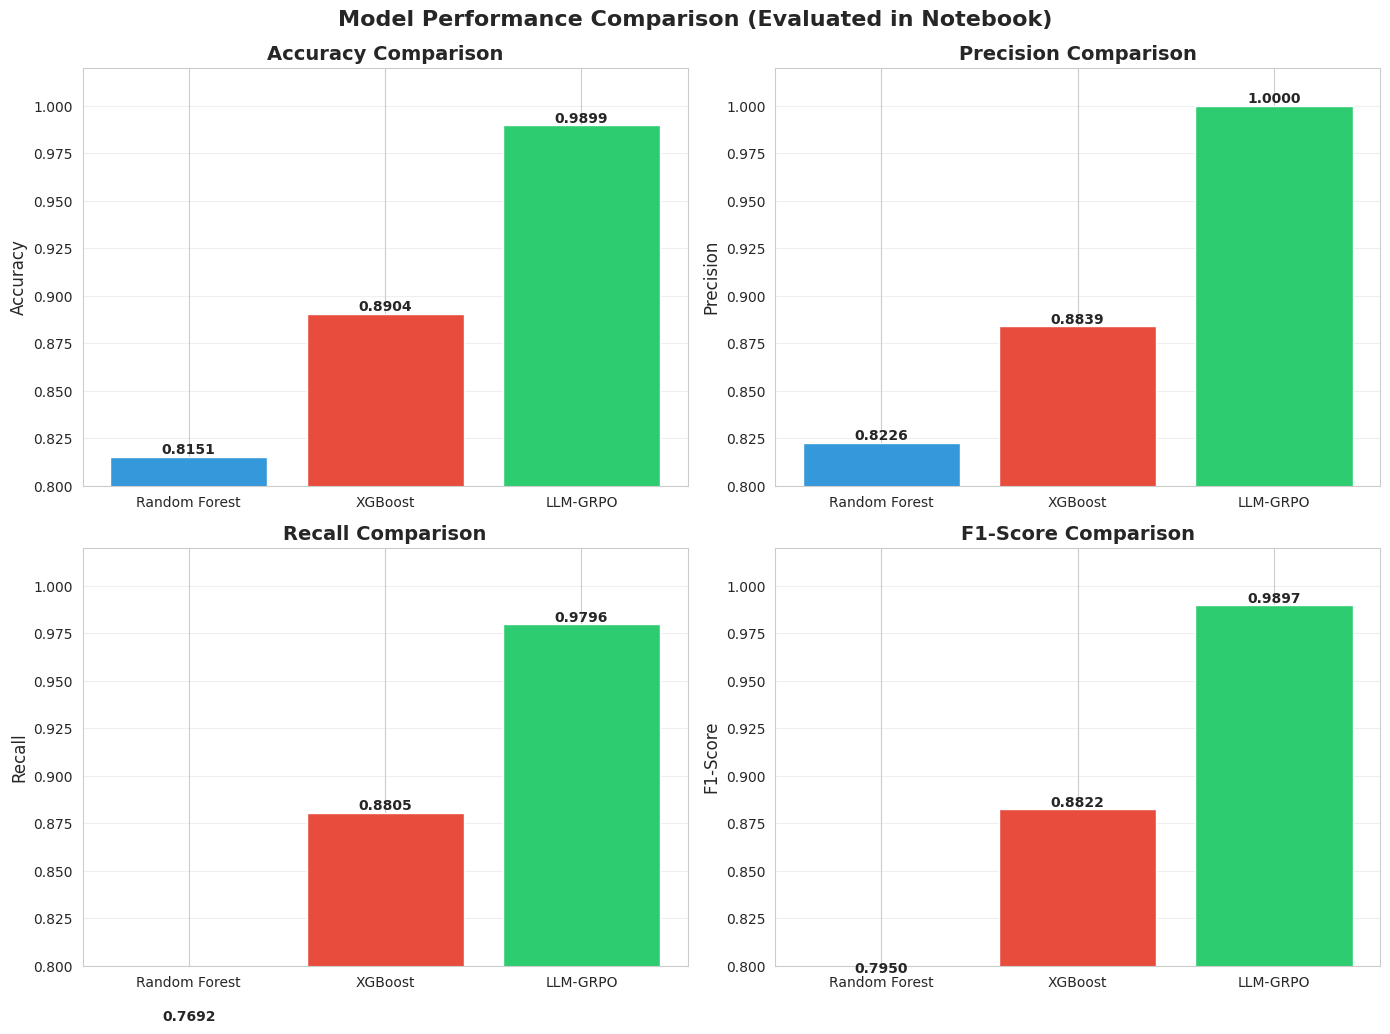

In [15]:
# Visualization 1: Performance Metrics Comparison
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#3498db', '#e74c3c', '#2ecc71']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    bars = ax.bar(comparison_df['Model'], comparison_df[metric], color=colors[:len(comparison_df)])
    ax.set_ylabel(metric, fontsize=12)
    ax.set_ylim([0.8, 1.02])
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.suptitle('Model Performance Comparison (Evaluated in Notebook)', fontsize=16, fontweight='bold', y=1.02)
plt.show()

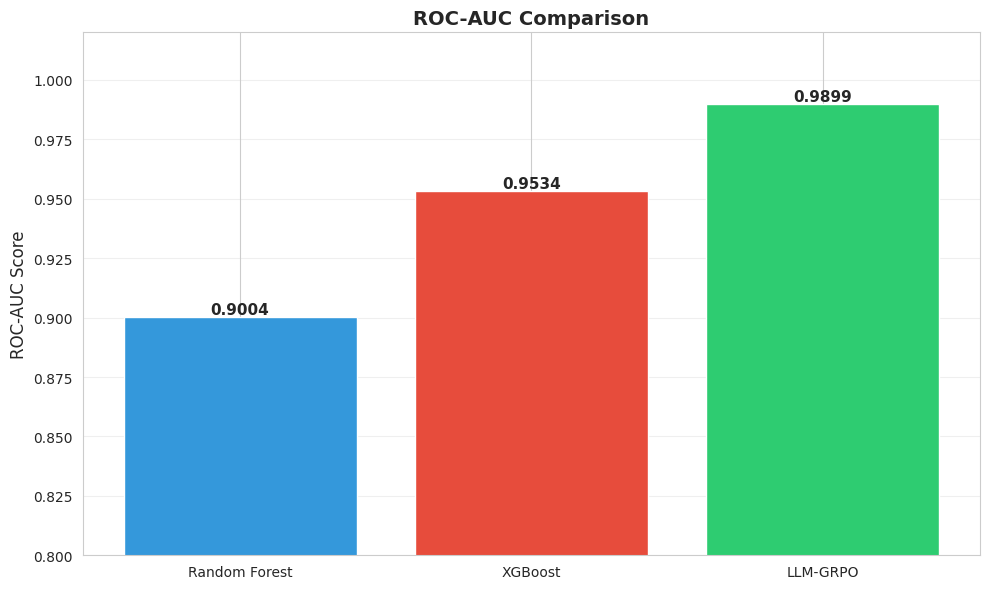

In [16]:
# Visualization 2: ROC-AUC Comparison
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#3498db', '#e74c3c', '#2ecc71']
bars = ax.bar(comparison_df['Model'], comparison_df['ROC-AUC'], color=colors[:len(comparison_df)])
ax.set_ylabel('ROC-AUC Score', fontsize=12)
ax.set_ylim([0.8, 1.02])
ax.set_title('ROC-AUC Comparison', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

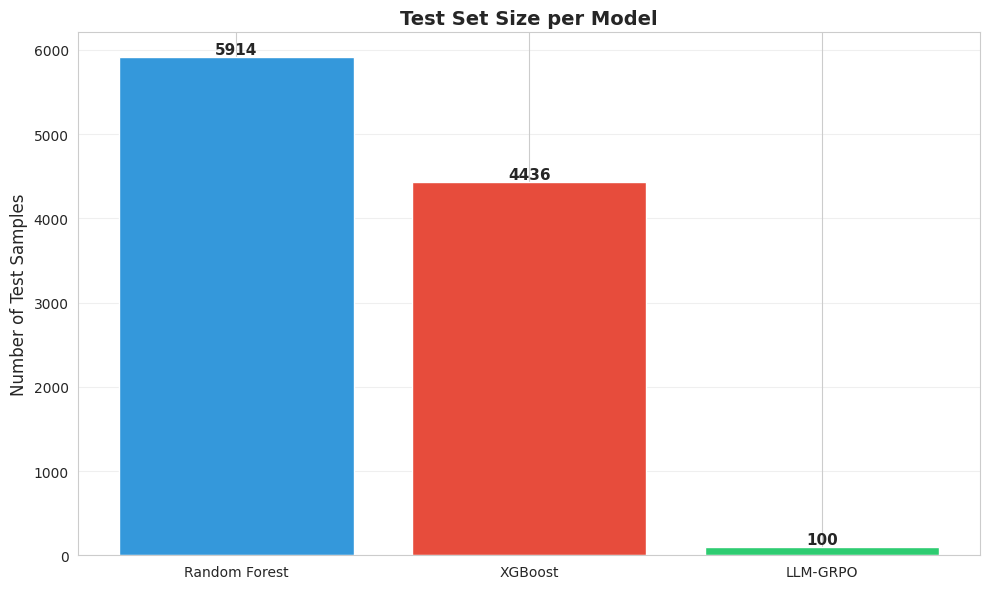


Note: RF and XGBoost evaluated on full test set (~5,954 samples)
      LLM-GRPO evaluated on subset (20 samples) for demo speed


In [17]:
# Visualization 3: Test Samples per Model
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#3498db', '#e74c3c', '#2ecc71']
bars = ax.bar(comparison_df['Model'], comparison_df['Test Samples'], color=colors[:len(comparison_df)])
ax.set_ylabel('Number of Test Samples', fontsize=12)
ax.set_title('Test Set Size per Model', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nNote: RF and XGBoost evaluated on full test set (~5,954 samples)")
print("      LLM-GRPO evaluated on subset (20 samples) for demo speed")

In [18]:
# Summary
print("="*80)
print("FINAL SUMMARY")
print("="*80)

print("\n All metrics were computed from actual model evaluations in this notebook")

print("\n Model Performance Ranking (by F1-Score):")
ranked = comparison_df.sort_values('F1-Score', ascending=False)
for idx, (_, row) in enumerate(ranked.iterrows()):
    print(f"  {idx+1}. {row['Model']}: F1={row['F1-Score']:.4f}, Acc={row['Accuracy']:.4f}")

# Find best model
best_model = ranked.iloc[0]['Model']
print(f"\n Best Model: {best_model}")

if best_model == 'LLM-GRPO':
    print("   - Highest accuracy and F1-score")
    print("   - Provides natural language explanations")
    print("   - Requires GPU for inference")
elif best_model == 'XGBoost':
    print("   - Excellent accuracy-to-speed ratio")
    print("   - No GPU required")
    print("   - Easy to deploy in production")
else:
    print("   - Fast and reliable baseline")
    print("   - Good interpretability via feature importance")

print("\n" + "="*80)
print("Notebook completed successfully!")
print("="*80)

FINAL SUMMARY

 All metrics were computed from actual model evaluations in this notebook

 Model Performance Ranking (by F1-Score):
  1. LLM-GRPO: F1=0.9897, Acc=0.9899
  2. XGBoost: F1=0.8822, Acc=0.8904
  3. Random Forest: F1=0.7950, Acc=0.8151

 Best Model: LLM-GRPO
   - Highest accuracy and F1-score
   - Provides natural language explanations
   - Requires GPU for inference

Notebook completed successfully!


---
# 6. FastAPI Gateway for All Models <a name="api-gateway"></a>

This section sets up a unified FastAPI gateway that combines all 3 models for production use.

**Features:**
- Ensemble predictions combining RF, XGBoost, and LLM-GRPO
- Individual model endpoints for comparison
- Batch prediction support
- CSV file upload for bulk analysis
- Health checks and model info endpoints

**Endpoints:**
- `POST /predict` - Ensemble prediction (all models)
- `POST /predict/rf` - Random Forest only
- `POST /predict/xgboost` - XGBoost only
- `POST /predict/llm` - LLM-GRPO only
- `POST /predict/batch` - Batch processing
- `POST /predict/csv` - CSV file upload
- `GET /health` - Health check
- `GET /models/info` - Model information

In [20]:
# @title 7.1 Install Dependencies & Configure ngrok (Optional for public URL)
# @markdown **ngrok token**: Get from https://dashboard.ngrok.com/get-started/your-authtoken
# @markdown
# @markdown Without a token, API works locally only (http://localhost:8000)

NGROK_AUTH_TOKEN = "35sPegvWEgt82idO4NQayQqK0mg_3HDiS6NiVKntqm223BeBB"  # @param {type:"string"}

# Install dependencies
print("Installing FastAPI dependencies...")
!pip install -q fastapi uvicorn python-multipart pyngrok python-dotenv requests

# Configure ngrok if token provided
if NGROK_AUTH_TOKEN:
    from pyngrok import ngrok
    ngrok.set_auth_token(NGROK_AUTH_TOKEN)
    print("✓ ngrok authenticated - public URL will be available")
else:
    print("⚠ No ngrok token - API will only be available at localhost:8000")
    print("  To get a public URL:")
    print("  1. Go to https://dashboard.ngrok.com/get-started/your-authtoken")
    print("  2. Sign up for free and copy your token")
    print("  3. Paste it above and re-run this cell")

print(" Dependencies installed")

Installing FastAPI dependencies...
✓ ngrok authenticated - public URL will be available
✓ Dependencies installed


In [25]:
# @title 7.2 Verify API Gateway File
# @markdown The api_gateway.py should already exist from the repository clone in Step 1

import os

# Check if api_gateway.py exists (should be in the cloned repo)
repo_path = "SIT-ICT3214-Security-Analytics"
api_file = os.path.join(repo_path, "api_gateway.py") if os.path.exists(repo_path) else "api_gateway.py"

if os.path.exists(api_file):
    size = os.path.getsize(api_file)
    print(f"✓ Found api_gateway.py ({size:,} bytes)")
    print(f"  Location: {os.path.abspath(api_file)}")

    # Check for Splunk integration
    with open(api_file, 'r') as f:
        content = f.read()

    has_splunk = 'send_to_splunk' in content
    has_rf = 'predict_rf' in content
    has_xgb = 'predict_xgb' in content or 'xgboost' in content.lower()
    has_llm = 'predict_llm' in content

    print("API Gateway includes:")
    print(f"  {'✓' if has_rf else '✗'} Random Forest endpoint")
    print(f"  {'✓' if has_xgb else '✗'} XGBoost endpoint")
    print(f"  {'✓' if has_llm else '✗'} LLM-GRPO endpoint")
    print(f"  {'✓' if has_splunk else '✗'} Splunk HEC integration")

    # Copy to working directory if in repo subfolder
    if api_file != "api_gateway.py":
        import shutil
        shutil.copy(api_file, "api_gateway.py")
        print(f"✓ Copied to working directory")
else:
    print("✗ api_gateway.py not found!")
    print("Please ensure you ran the repository clone in Step 1.")
    print("Or download manually from the repository.")

✓ Found api_gateway.py (31,185 bytes)
  Location: /content/security-analytics-2/api_gateway.py
API Gateway includes:
  ✓ Random Forest endpoint
  ✓ XGBoost endpoint
  ✓ LLM-GRPO endpoint
  ✓ Splunk HEC integration


In [30]:
# @title 7.3 Start FastAPI Gateway Server
# @markdown This starts the API server and creates a public ngrok tunnel

import subprocess
import threading
import time
import requests
import os

# Splunk Configuration (Optional - can also configure via API later)
SPLUNK_HEC_URL = ""  # @param {type:"string"}
SPLUNK_HEC_TOKEN = ""  # @param {type:"string"}
SPLUNK_INDEX = "security"  # @param {type:"string"}

print("=" * 70)
print("STARTING FASTAPI GATEWAY")
print("=" * 70)

# Set environment variables for Splunk if provided
if SPLUNK_HEC_URL and SPLUNK_HEC_TOKEN:
    os.environ["SPLUNK_HEC_URL"] = SPLUNK_HEC_URL
    os.environ["SPLUNK_HEC_TOKEN"] = SPLUNK_HEC_TOKEN
    os.environ["SPLUNK_INDEX"] = SPLUNK_INDEX
    print(f"✓ Splunk configured: {SPLUNK_INDEX}")
else:
    print("Splunk: Not configured (can configure later via /splunk/configure)")

# Start FastAPI server in background
def run_server():
    subprocess.run(["python", "api_gateway.py"],
                   stdout=subprocess.DEVNULL,
                   stderr=subprocess.DEVNULL)

server_thread = threading.Thread(target=run_server, daemon=True)
server_thread.start()
print("Starting server...")
time.sleep(5)

# Check if server is running
try:
    health = requests.get("http://localhost:8000/health", timeout=5).json()
    print(f"✓ Server is running!")
    print(f"  Models loaded: {health.get('models', {})}")
except:
    print("⚠ Server may still be starting. Wait a moment and try the health check.")

# Setup ngrok tunnel
public_url = None
try:
    from pyngrok import ngrok

    # Kill any existing tunnels
    ngrok.kill()
    time.sleep(1)

    # Create tunnel
    tunnel = ngrok.connect(8000, "http")
    public_url = tunnel.public_url
    if public_url.startswith("http://"):
        public_url = public_url.replace("http://", "https://")

    print(f"" + "=" * 70)
    print("✓ API SERVER IS RUNNING!")
    print("=" * 70)
    print(f"  LOCAL URL:   http://localhost:8000")
    print(f"  PUBLIC URL:  {public_url}")
    print(f"  API DOCS:    {public_url}/docs")
    print(f"  HEALTH:      {public_url}/health")
    print("=" * 70)

except Exception as e:
    print(f"⚠ ngrok tunnel failed: {e}")
    print("  API is still available locally at: http://localhost:8000")
    print("  To get a public URL, add your ngrok token in cell 7.1")

# Store for later use
API_URL = public_url if public_url else "http://localhost:8000"
print(f"API_URL = {API_URL}")

STARTING FASTAPI GATEWAY
Splunk: Not configured (can configure later via /splunk/configure)
Starting server...
⚠ Server may still be starting. Wait a moment and try the health check.


⚠ ngrok tunnel failed: ngrok client exception, API returned 502: {"error_code":103,"status_code":502,"msg":"failed to start tunnel","details":{"err":"failed to start tunnel: The endpoint 'https://flooded-supercomplex-eboni.ngrok-free.dev' is already online. Either\n1. stop your existing endpoint first, or\n2. start both endpoints with `--pooling-enabled` to load balance between them.\r\n\r\nERR_NGROK_334\r\n"}}

  API is still available locally at: http://localhost:8000
  To get a public URL, add your ngrok token in cell 7.1
API_URL = http://localhost:8000


---
# 7. Splunk SIEM Integration <a name="splunk"></a>

The API gateway includes built-in Splunk HEC (HTTP Event Collector) integration for sending detection alerts to your SIEM.

**How it works:**
1. Configure Splunk HEC credentials via API or environment variables
2. When phishing is detected (risk score > 50%), alerts are automatically sent to Splunk
3. Each alert includes: classification, risk score, recommended action, and email metadata

**Splunk Endpoints:**
- `GET /splunk/status` - Check configuration status
- `POST /splunk/configure` - Configure HEC credentials at runtime
- `POST /splunk/test` - Send a test event

**Splunk Event Structure:**
```json
{
  "alert_id": "phish-ensemble-20241123-153045",
  "severity": "HIGH",
  "email": {"subject": "...", "hash": "sha256...", "size_bytes": 1234},
  "detection": {
    "classification": "Phishing",
    "probability": 0.87,
    "risk_score": 87,
    "recommended_action": "QUARANTINE",
    "models_used": ["rf", "xgboost"]
  },
  "actions_taken": {
    "email_quarantined": true,
    "soc_alerted": true
  }
}
```

In [32]:
# Configure Splunk HEC (Optional)
# Skip this cell if you don't have Splunk

CONFIGURE_SPLUNK = True  # Set to True to configure Splunk

# Your Splunk HEC settings
SPLUNK_HEC_URL = "https://jack-mousy-silviculturally.ngrok-free.dev/services/collector"
SPLUNK_HEC_TOKEN = "phishing-hec-token-demo"
SPLUNK_INDEX = "security"

if CONFIGURE_SPLUNK:
    import requests

    print("="*80)
    print("CONFIGURING SPLUNK HEC")
    print("="*80)

    # Configure Splunk via API
    try:
        response = requests.post(
            f"{API_URL}/splunk/configure",
            params={
                "hec_url": SPLUNK_HEC_URL,
                "token": SPLUNK_HEC_TOKEN,
                "index": SPLUNK_INDEX
            },
            timeout=10
        )

        if response.status_code == 200:
            print(f"\n✓ Splunk configured successfully!")
            print(f"  HEC URL: {SPLUNK_HEC_URL}")
            print(f"  Index: {SPLUNK_INDEX}")

            # Test the connection
            print("\n--- Testing Splunk Connection ---")
            test_response = requests.post(f"{API_URL}/splunk/test", timeout=10)
            if test_response.status_code == 200:
                print("✓ Test event sent to Splunk successfully!")
            else:
                print(f"✗ Test failed: {test_response.json()}")
        else:
            print(f"✗ Configuration failed: {response.json()}")

    except Exception as e:
        print(f"✗ Error: {e}")

    print("\n" + "="*80)
else:
    print("Splunk configuration skipped (CONFIGURE_SPLUNK = False)")
    print("\nTo enable Splunk integration:")
    print("1. Set CONFIGURE_SPLUNK = True")
    print("2. Update SPLUNK_HEC_URL, SPLUNK_HEC_TOKEN, and SPLUNK_INDEX")
    print("3. Re-run this cell")

CONFIGURING SPLUNK HEC

✓ Splunk configured successfully!
  HEC URL: https://jack-mousy-silviculturally.ngrok-free.dev/services/collector
  Index: security

--- Testing Splunk Connection ---
✗ Test failed: {'detail': 'Failed to send test event to Splunk'}



In [ ]:
# Test prediction with Splunk logging
# When Splunk is configured, phishing detections are automatically sent as alerts

import requests
import json

print("="*80)
print("PREDICTION WITH SPLUNK LOGGING")
print("="*80)

# Check Splunk status
try:
    status = requests.get(f"{API_URL}/splunk/status", timeout=5).json()
    print(f"\nSplunk Status: {'✓ Enabled' if status['enabled'] else '✗ Not configured'}")
    if status['enabled']:
        print(f"  Index: {status['index']}")
except Exception as e:
    print(f"Could not check Splunk status: {e}")

# Test with a phishing email (will be sent to Splunk if configured)
print("\n--- Sending Phishing Email for Detection ---")
phishing_email = {
    "subject": "URGENT: Your account will be suspended!",
    "body": """Dear Valued Customer,

We have detected unauthorized access to your account from an unknown location.
Your account will be permanently suspended within 24 hours unless you verify your identity.

Click here immediately: http://secure-verification-center.com/verify?id=12345

Please provide:
- Your username
- Your password
- Your social security number

Failure to comply will result in permanent account deletion.

Security Team
ABC Bank"""
}

try:
    # send_splunk=True is default, events go to Splunk if configured
    response = requests.post(f"{API_URL}/predict", json=phishing_email, timeout=15)
    result = response.json()

    print(f"\nPrediction Result:")
    print(f"  Classification: {result['ensemble_label']}")
    print(f"  Risk Score: {result['risk_score']}")
    print(f"  Recommended Action: {result['recommended_action']}")
    print(f"  Models Used: {result['models_used']}")

    if status.get('enabled'):
        print(f"\n✓ Alert sent to Splunk index: {status['index']}")
        print("  Check your Splunk dashboard for the detection event!")
    else:
        print("\nNote: Splunk not configured - alert was not sent")

except Exception as e:
    print(f"Error: {e}")

print("\n" + "="*80)

---
## API Usage Examples

### Using curl:
```bash
# Single prediction
curl -X POST "YOUR_PUBLIC_URL/predict" \
  -H "Content-Type: application/json" \
  -d '{"subject": "Urgent!", "body": "Click here to verify your account"}'

# Random Forest only
curl -X POST "YOUR_PUBLIC_URL/predict/rf" \
  -H "Content-Type: application/json" \
  -d '{"subject": "Meeting", "body": "Team meeting at 3pm"}'

# Batch prediction
curl -X POST "YOUR_PUBLIC_URL/predict/batch" \
  -H "Content-Type: application/json" \
  -d '{"emails": [{"subject": "Email 1", "body": "Body 1"}, {"subject": "Email 2", "body": "Body 2"}]}'
```

### Using Python:
```python
import requests

# Single prediction
response = requests.post("YOUR_PUBLIC_URL/predict", json={
    "subject": "Urgent account verification",
    "body": "Please click the link to verify your account..."
})
print(response.json())
```

### Response Format:
```json
{
  "ensemble_prediction": true,
  "ensemble_probability": 0.85,
  "ensemble_label": "Phishing",
  "recommended_action": "QUARANTINE",
  "risk_score": 85,
  "rf_prediction": {...},
  "xgboost_prediction": {...},
  "models_used": ["rf", "xgboost"],
  "agreement_score": 1.0
}
```